In [2]:
# CRFNet: A Deep Convolutional Network to Learn the Potentials of a CRF for Semantic Segmentation
# Kaggle Implementation

# Cell 1: Setup Environment and Clone Repository
# Execute this cell to set up your environment
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm.notebook import tqdm
from glob import glob

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
# Clone the repository if it doesn't exist
!rm -rf CRFNet-RS # Remove old version if exists
!git clone https://github.com/Ayana-Inria/CRFNet-RS.git
sys.path.append('/kaggle/working/CRFNet-RS')

# Install dependencies
# !pip install -r /kaggle/working/CRFNet-RS/requirements.txt


# !rm -rf cvae-quadratreeMRF # Remove old version if exists
# !git clone https://github.com/realjules/cvae-quadratreeMRF.git
# import sys
# sys.path.append('/kaggle/working/cvae-quadratreeMRF')

Cloning into 'CRFNet-RS'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.51 MiB | 13.60 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [4]:
# Cell 2: Configure Paths and Parameters
# Configuration parameters
WINDOW_SIZE = (256, 256)  # Patch size for training
STRIDE = 32  # Stride for testing inference
IN_CHANNELS = 3  # Number of input channels (RGB/IRRG)
BATCH_SIZE = 10  # Mini-batch size
EPOCHS = 1  # Number of training epochs
SAVE_EPOCH = 10  # Save model every N epochs
BASE_LR = 0.01  # Base learning rate
WEIGHT_DECAY = 0.0005  # Weight decay for optimizer

# Dataset parameters
DATASET_TYPE = "Vaihingen"  # Options: "Vaihingen" or "Potsdam"
GT_TYPE = "conncomp"  # Options: "full", "conncomp", "ero"
ERO_DISK_SIZE = 8  # Size of erosion disk for ground truth processing

# Organize folders
DATA_ROOT = "/kaggle/input/potsdamvaihingen"
OUTPUT_ROOT = "/kaggle/working/output"
EXPERIMENT_NAME = f"CRFNet_{DATASET_TYPE}_{GT_TYPE}"

# Create output directory
os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(f"{OUTPUT_ROOT}/{EXPERIMENT_NAME}", exist_ok=True)

# Set paths based on dataset
if DATASET_TYPE == "Vaihingen":
    DATA_FOLDER = f"{DATA_ROOT}/ISPRS_semantic_labeling_Vaihingen"
    train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
    test_ids = ['5', '15', '21', '30']
else:  # Potsdam
    DATA_FOLDER = f"{DATA_ROOT}/ISPRS_semantic_labeling_Potsdam"
    train_ids = ['3_11', '4_11', '5_10', '6_7', '6_8', '6_9', '7_7', '7_8', '7_9', '7_10']
    test_ids = ['3_12', '4_10', '4_12', '5_11', '6_12']

# Data file paths
DATA_FILES = f"{DATA_FOLDER}/top/top_mosaic_09cm_area{{}}.tif"
LABEL_FILES = f"{DATA_FOLDER}/gts_for_participants/top_mosaic_09cm_area{{}}.tif"
ERODED_FILES = f"{DATA_FOLDER}/dsm/top_mosaic_09cm_area{{}}_noBoundary.tif"

# Class labels
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]
N_CLASSES = len(LABELS)

In [5]:
# Open the file and fix the indentation
!cat /kaggle/working/CRFNet-RS/utils/utils_network.py | head -90
!sed -i '89s/^/        /' /kaggle/working/CRFNet-RS/utils/utils_network.py
from net.net import CRFNet

# -*- coding: utf-8 -*-
"""
Created on Sun Apr  3 17:34:32 2022

@author: marti
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import operator
import numpy as np



class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX

In [6]:
# Cell 3: Import Required Modules
# Import all the necessary modules from the cloned repository
from dataset.dataset import ISPRS_dataset
from utils.utils_dataset import convert_from_color, convert_to_color, disk
from utils.utils import metrics, sliding_window, count_sliding_window, grouper
from utils.export_result import set_output_location, export_results
from net.net import CRFNet
from net.loss import CrossEntropy2d
from skimage import io
import torch.optim as optim
from torch.autograd import Variable

# Display dataset information
print(f"Dataset: {DATASET_TYPE}")
print(f"Ground Truth Type: {GT_TYPE}")
print(f"Training on {len(train_ids)} tiles: {train_ids}")
print(f"Testing on {len(test_ids)} tiles: {test_ids}")
print(f"Using {'GPU' if torch.cuda.is_available() else 'CPU'} for computation")

Dataset: Vaihingen
Ground Truth Type: conncomp
Training on 12 tiles: ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Testing on 4 tiles: ['5', '15', '21', '30']
Using GPU for computation


In [7]:
# Cell 4: Initialize Model and Optimizer
# Initialize the CRFNet model
net = CRFNet(n_channels=IN_CHANNELS, n_classes=N_CLASSES, bilinear=True)

# Setup optimizer and learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=BASE_LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

# Move model to GPU if available
if torch.cuda.is_available():
    net.cuda()
    WEIGHTS = torch.ones(N_CLASSES).cuda()
else:
    WEIGHTS = torch.ones(N_CLASSES)

In [8]:
# Cell 5: Create Datasets and Data Loaders
# Initialize training and testing datasets
train_set = ISPRS_dataset(
    ids=train_ids,
    ids_type='TRAIN',
    gt_type=GT_TYPE,
    gt_modification=disk(ERO_DISK_SIZE),
    data_files=DATA_FILES,
    label_files=LABEL_FILES,
    window_size=WINDOW_SIZE,
    cache=True,
    augmentation=True
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
print(f"Created training loader with approximately {len(train_set) // BATCH_SIZE} batches per epoch")

Created training loader with approximately 1000 batches per epoch


In [9]:
# Cell 6: Training Function
# Function to train the network
def train_model(net, optimizer, scheduler, train_loader, epochs, save_epoch, weights):
    """
    Train the CRFNet model
    """
    # Import any missing modules needed for training
    import torch.nn.functional as F
    import cv2
    from utils.utils_network import compute_class_weight
    
    # Initialize loss tracking
    max_iterations = epochs * len(train_loader)
    losses = np.zeros(max_iterations)
    mean_losses = np.zeros(max_iterations)
    iter_ = 0
    
    # Training loop
    for e in tqdm(range(1, epochs + 1), desc="Epochs"):
        # Set model to training mode
        net.train()
        
        # Process each batch
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {e}", leave=False)):
            # Process targets for multi-scale supervision
            target_np = target.data.cpu().numpy()
            target_np = np.transpose(target_np, [1, 2, 0])
            
            # Create multi-scale targets for different decoder outputs
            target3 = np.transpose(cv2.resize(target_np, dsize=(128, 128), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target2 = np.transpose(cv2.resize(target_np, dsize=(64, 64), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target1 = np.transpose(cv2.resize(target_np, dsize=(32, 32), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target_np = np.transpose(target_np, [2, 0, 1])
            
            # Move data to device
            if torch.cuda.is_available():
                data = Variable(data.cuda())
                target = Variable(torch.from_numpy(target_np).cuda())
                target1_tensor = Variable(torch.from_numpy(target1).type(torch.LongTensor).cuda())
                target2_tensor = Variable(torch.from_numpy(target2).type(torch.LongTensor).cuda())
                target3_tensor = Variable(torch.from_numpy(target3).type(torch.LongTensor).cuda())
            else:
                data = Variable(data)
                target = Variable(torch.from_numpy(target_np))
                target1_tensor = Variable(torch.from_numpy(target1).type(torch.LongTensor))
                target2_tensor = Variable(torch.from_numpy(target2).type(torch.LongTensor))
                target3_tensor = Variable(torch.from_numpy(target3).type(torch.LongTensor))
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output, out_fc, out_neigh, _ = net(data)
            
            # Calculate multi-scale losses
            loss = CrossEntropy2d(output, target, weight=weights)
            
            # Multi-scale supervision losses
            if torch.cuda.is_available():
                loss_fc1 = CrossEntropy2d(out_fc[0], target1_tensor, weight=compute_class_weight(target1).cuda())
                loss_fc2 = CrossEntropy2d(out_fc[1], target2_tensor, weight=compute_class_weight(target2).cuda())
                loss_fc3 = CrossEntropy2d(out_fc[2], target3_tensor, weight=compute_class_weight(target3).cuda())
            else:
                loss_fc1 = CrossEntropy2d(out_fc[0], target1_tensor, weight=compute_class_weight(target1))
                loss_fc2 = CrossEntropy2d(out_fc[1], target2_tensor, weight=compute_class_weight(target2))
                loss_fc3 = CrossEntropy2d(out_fc[2], target3_tensor, weight=compute_class_weight(target3))
            
            # Pairwise potential loss
            pairwise_loss = CrossEntropy2d(out_neigh, target, weight=weights)
            
            # Combine losses
            total_loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            # Record loss
            losses[iter_] = total_loss.item()
            mean_losses[iter_] = np.mean(losses[max(0, iter_-100):iter_+1])
            
            # Display progress every 100 iterations
            if iter_ % 100 == 0:
                # Visualize results
                with torch.no_grad():
                    # Convert to CPU for visualization
                    rgb = np.asarray(255 * np.transpose(data.cpu().numpy()[0], (1, 2, 0)), dtype='uint8')
                    pred = np.argmax(output.cpu().numpy()[0], axis=0)
                    gt = target.cpu().numpy()[0]
                    
                    # Calculate accuracy
                    from utils.utils import accuracy
                    acc = accuracy(pred, gt)
                    
                    # Print progress
                    print(f'Epoch {e}/{epochs} [{batch_idx}/{len(train_loader)} ({100*batch_idx/len(train_loader):.0f}%)] Loss: {total_loss.item():.4f} Acc: {acc:.2f}%')
                    
                    # Plot loss curve
                    plt.figure(figsize=(10, 4))
                    plt.plot(mean_losses[:iter_+1])
                    plt.title('Mean Loss')
                    plt.grid(True)
                    plt.xlabel('Iterations')
                    plt.ylabel('Loss')
                    plt.show()
                    
                    # Visualize predictions
                    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                    # ax1.imshow(rgb)
                    # ax1.set_title('RGB Input')
                    # ax2.imshow(convert_to_color(gt))
                    # ax2.set_title('Ground Truth')
                    # ax3.imshow(convert_to_color(pred))
                    # ax3.set_title('Prediction')
                    # plt.tight_layout()
                    # plt.show()
            
            iter_ += 1
        
        # Update learning rate
        scheduler.step()
        
        # Save model checkpoint
        if e % save_epoch == 0:
            model_path = f'{OUTPUT_ROOT}/{EXPERIMENT_NAME}/model_epoch{e}.pth'
            torch.save(net.state_dict(), model_path)
            print(f"Model saved to {model_path}")
    
    # Save final model
    final_model_path = f'{OUTPUT_ROOT}/{EXPERIMENT_NAME}/model_final.pth'
    torch.save(net.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    return final_model_path

In [13]:
def test_model(net, test_ids, test_images, test_labels, eroded_labels, labels, stride, batch_size, window_size, output_path=None):
    """
    Test the model on the provided test data
    
    Parameters:
    -----------
    net : nn.Module
        The trained neural network
    test_ids : list
        List of tile IDs for testing
    test_images : list
        List of test images (normalized to [0,1])
    test_labels : list
        List of test label images
    eroded_labels : list
        List of eroded label images
    labels : list
        List of class names
    stride : int
        Stride for the sliding window
    batch_size : int
        Batch size for testing
    window_size : tuple
        Size of the sliding window (h, w)
    output_path : str, optional
        Path to save results
        
    Returns:
    --------
    accuracy : float
        Overall accuracy of the model
    all_preds : list
        List of prediction maps
    all_gts : list
        List of ground truth maps
    """
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e, tile_id in zip(test_images, test_labels, eroded_labels, test_ids):
        print(f"Processing test tile {tile_id}...")
        pred = np.zeros(img.shape[:2] + (len(labels),))
        
        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, desc=f"Tile {tile_id}", leave=False)):
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            
            with torch.no_grad():
                image_patches = Variable(torch.from_numpy(image_patches).cuda())
                
                # Do the inference
                outs = net(image_patches)[0]
                outs = outs.data.cpu().numpy()
                
                # Fill in the results array
                for out, (x, y, w, h) in zip(outs, coords):
                    out = out.transpose((1,2,0))
                    pred[x:x+w, y:y+h] += out
        
        # Get the final prediction
        pred = np.argmax(pred, axis=-1)

        # Display the result
        if output_path:
            fig = plt.figure(figsize=(15, 5))
            fig.add_subplot(1,3,1)
            plt.imshow(np.asarray(255 * img, dtype='uint8'))
            plt.title(f'Original Image (Tile {tile_id})')
            fig.add_subplot(1,3,2)
            plt.imshow(convert_to_color(pred))
            plt.title('Prediction')
            fig.add_subplot(1,3,3)
            plt.imshow(gt)
            plt.title('Ground Truth')
            plt.tight_layout()
            plt.savefig(f"{output_path}/result_tile_{tile_id}.png")
            plt.show()
        
        all_preds.append(pred)
        all_gts.append(gt_e)
        
        # Compute metrics for this tile
        print(f"Metrics for tile {tile_id}:")
        metrics(pred.ravel(), gt_e.ravel(), labels)
    
    # Compute overall metrics
    print("\nOverall metrics:")
    accuracy = metrics(
        np.concatenate([p.ravel() for p in all_preds]), 
        np.concatenate([p.ravel() for p in all_gts]).ravel(), 
        labels
    )
    
    # Export results if output path is provided
    if output_path:
        title = "Quantitative results for CRFNet testing"
        export_results(
            all_preds, all_gts, 
            os.path.dirname(output_path), os.path.basename(output_path),
            confusionMat=True,
            prodAccuracy=True,
            averageAccuracy=True,
            kappaCoeff=True,
            title=title
        )
        
        # Save prediction images
        for pred, tile_id in zip(all_preds, test_ids):
            img = convert_to_color(pred)
            io.imsave(f"{output_path}/segmentation_result_area{tile_id}.png", img)
    
    return accuracy, all_preds, all_gts

Starting model training...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 1/1 [0/1000 (0%)] Loss: 3.7802 Acc: 19.07%


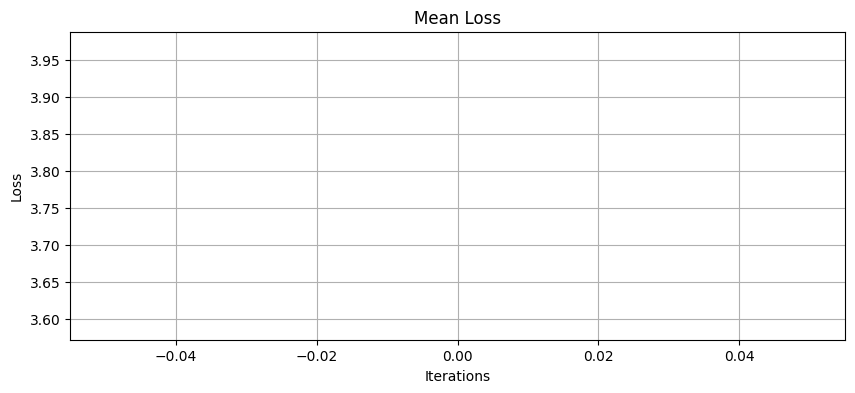

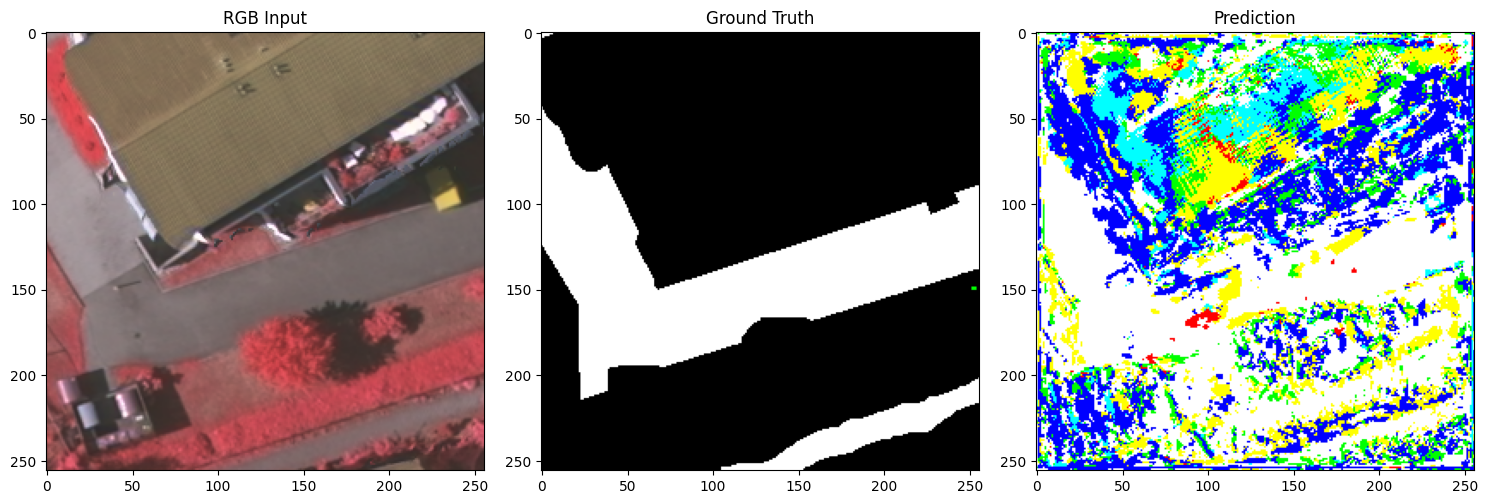

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 1/1 [100/1000 (10%)] Loss: 2.6157 Acc: 62.12%


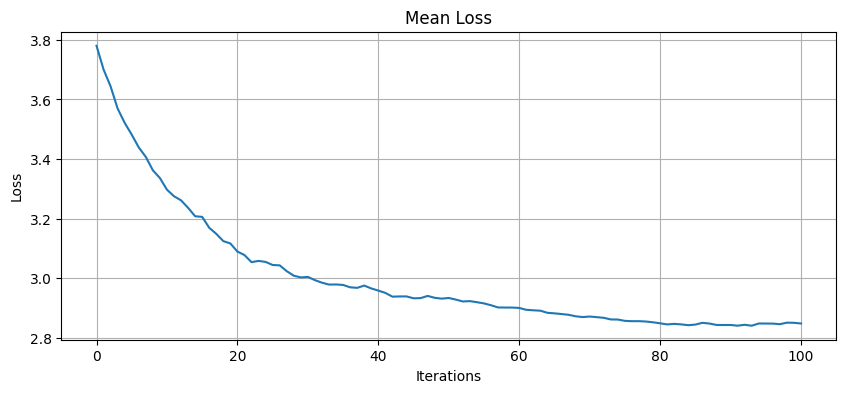

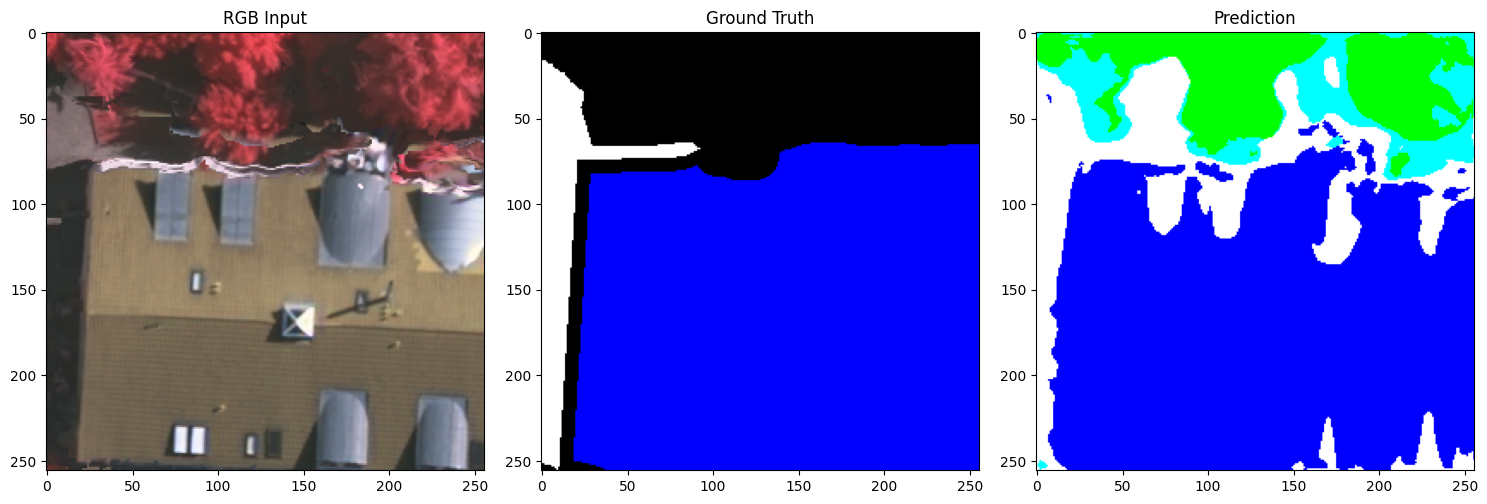

Epoch 1/1 [200/1000 (20%)] Loss: 2.7231 Acc: 62.22%


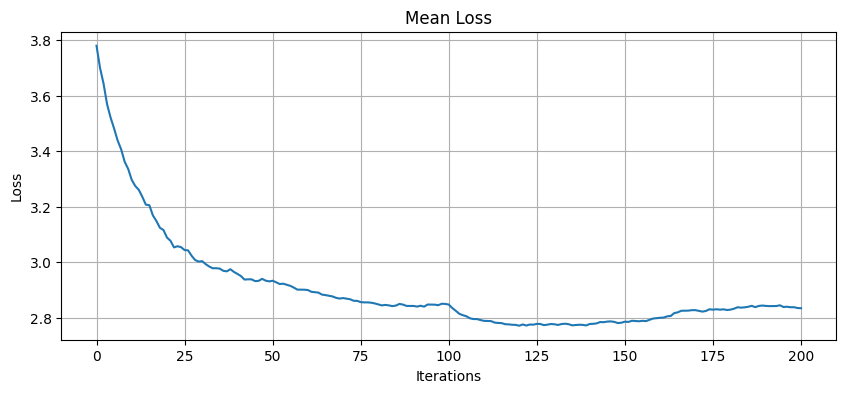

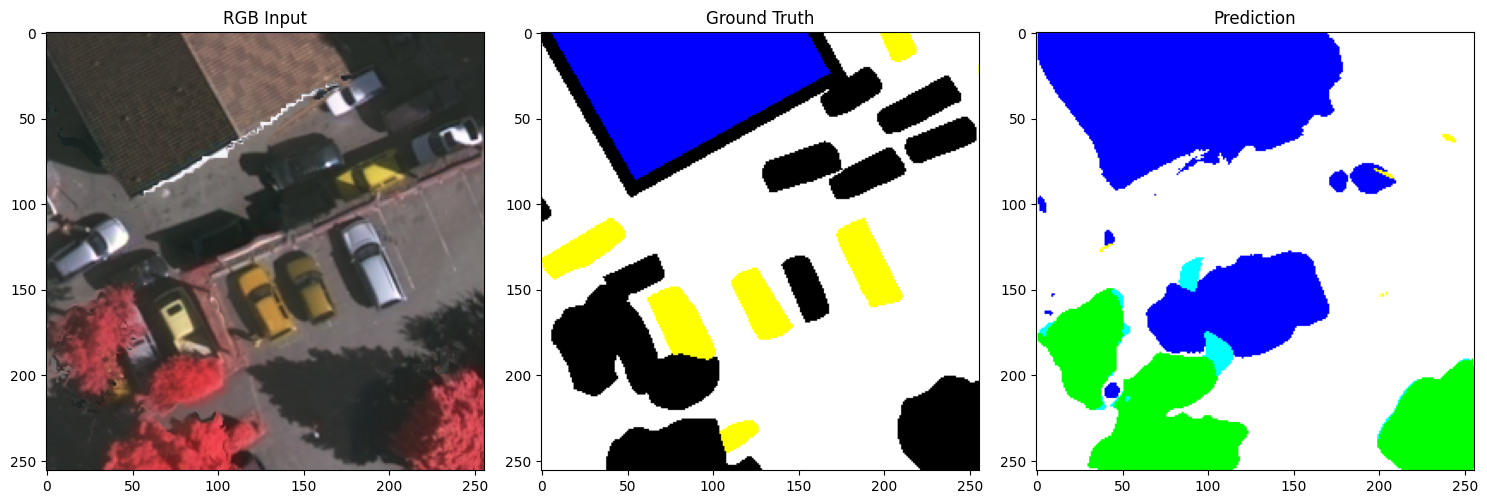

Epoch 1/1 [300/1000 (30%)] Loss: 3.1003 Acc: 8.07%


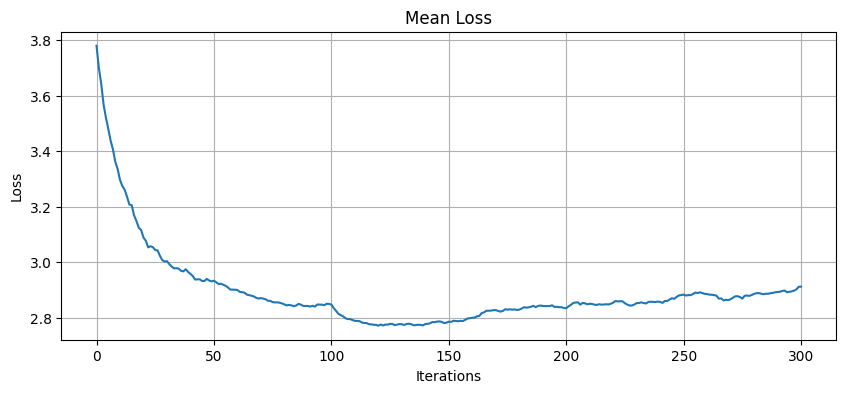

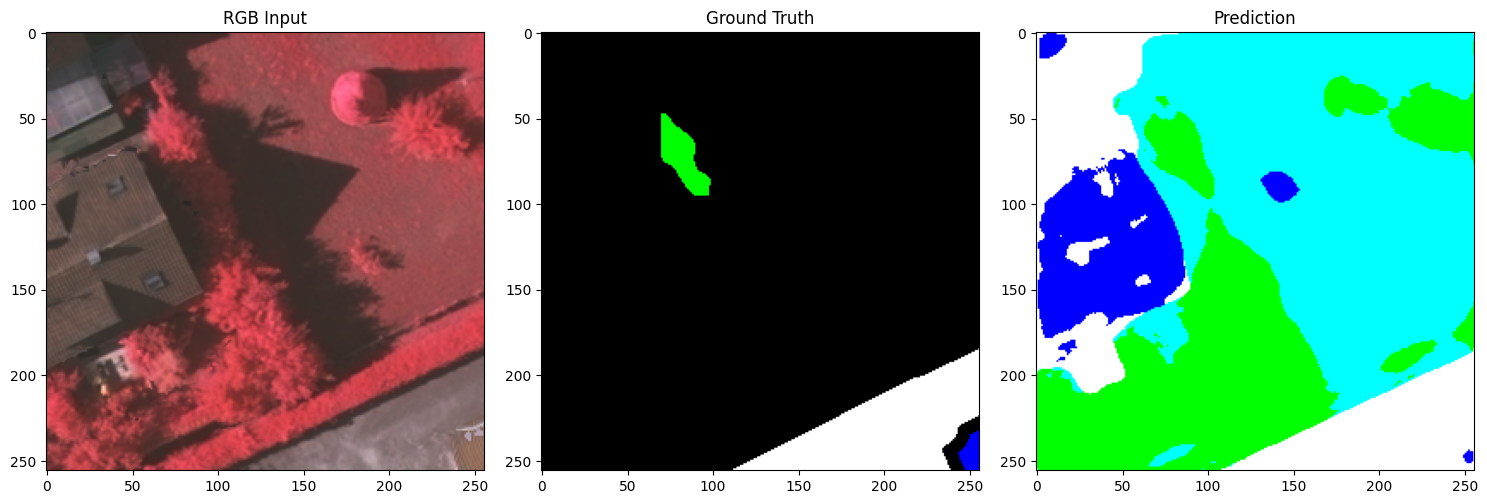

Epoch 1/1 [400/1000 (40%)] Loss: 2.8161 Acc: 11.63%


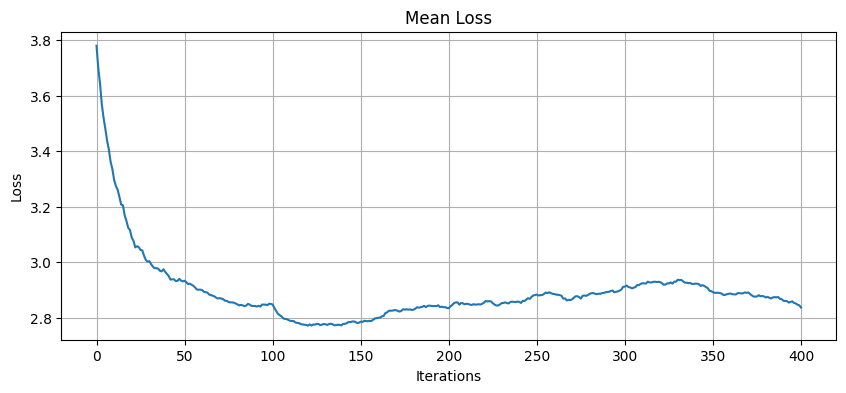

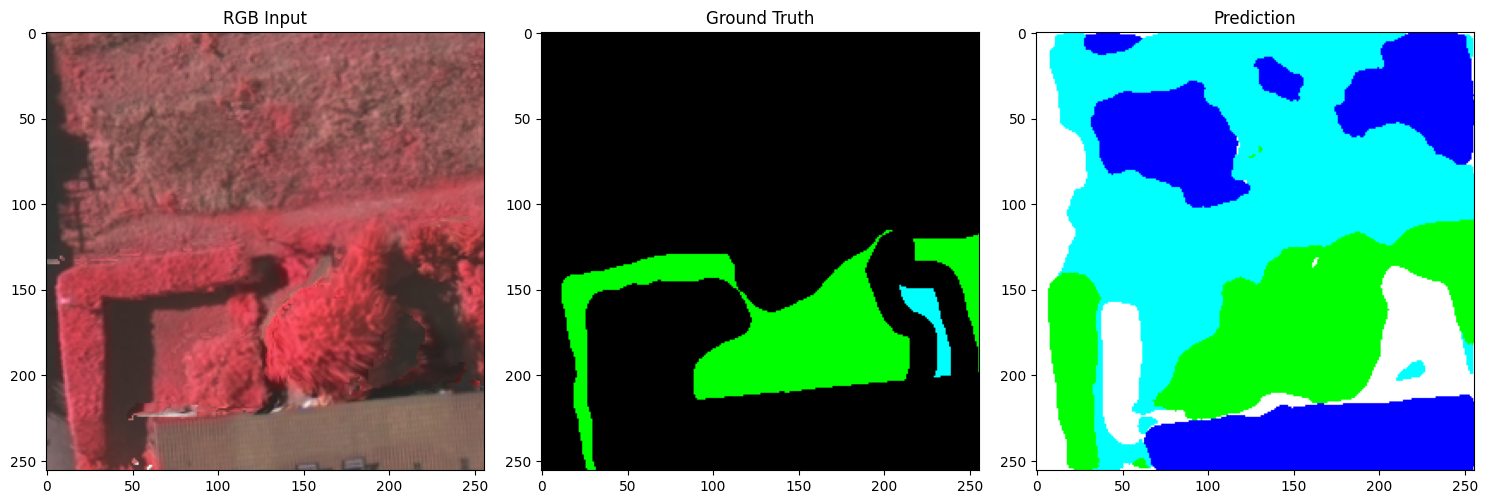

Epoch 1/1 [500/1000 (50%)] Loss: 2.7863 Acc: 26.63%


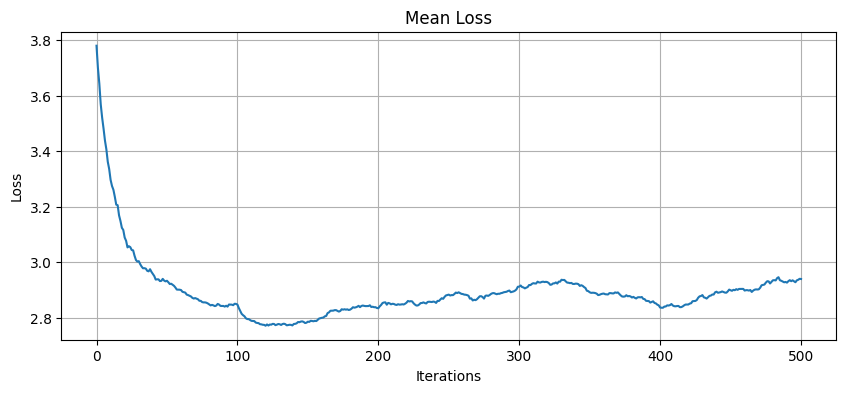

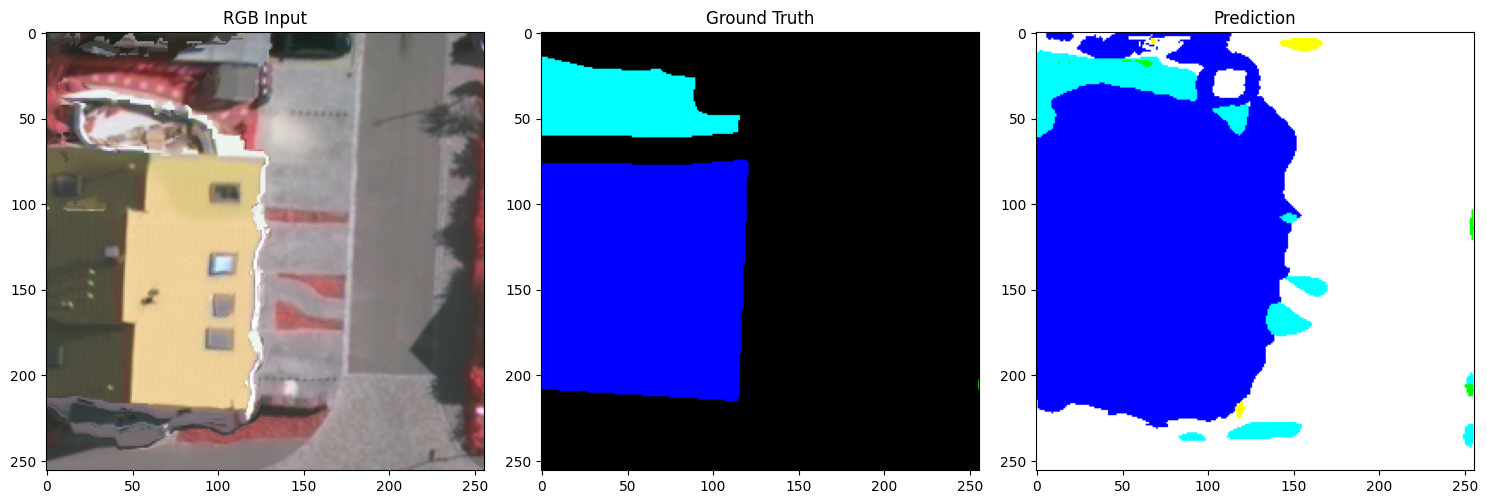

Epoch 1/1 [600/1000 (60%)] Loss: 3.4061 Acc: 2.82%


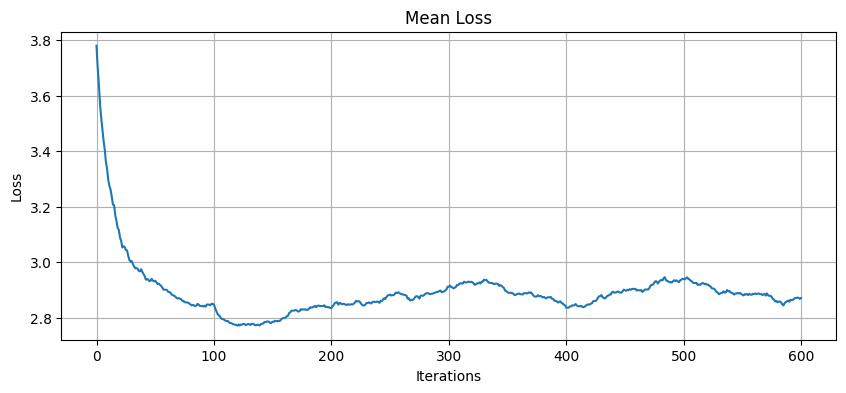

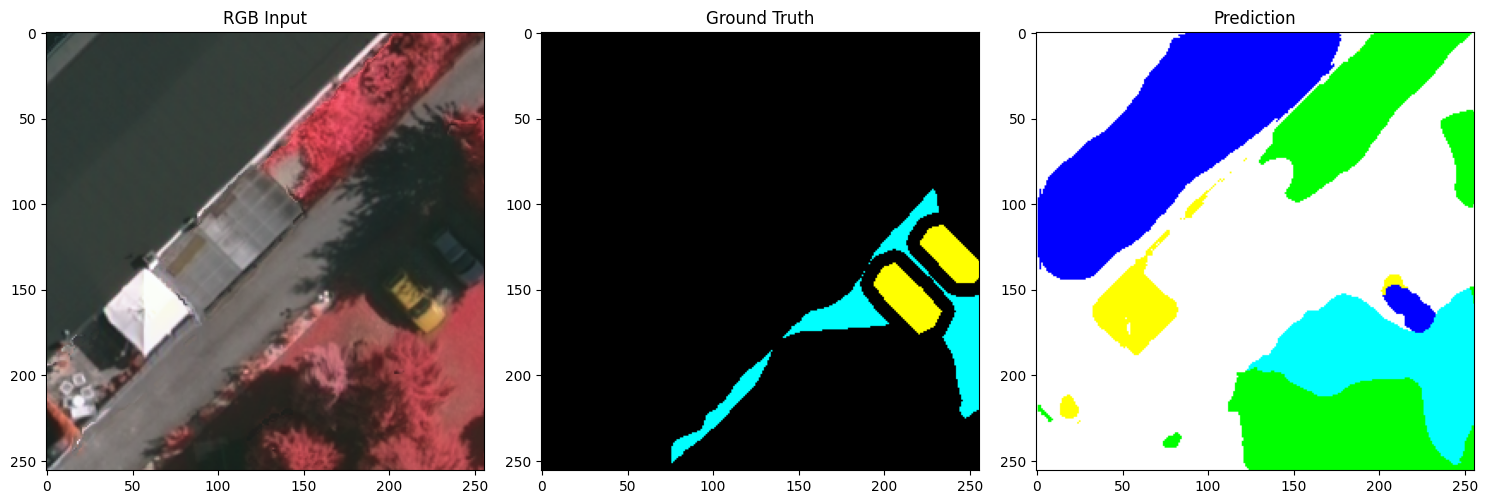

Epoch 1/1 [700/1000 (70%)] Loss: 2.9199 Acc: 0.00%


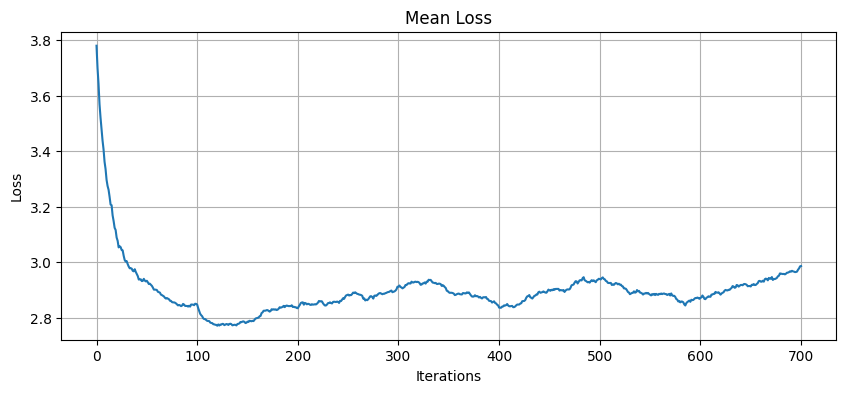

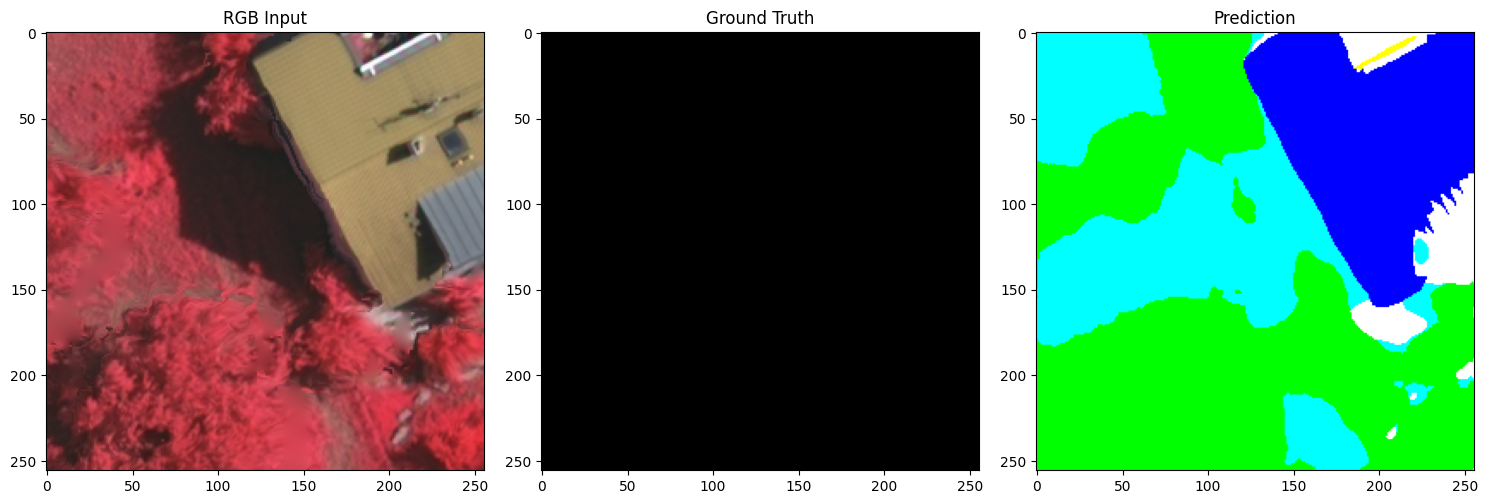

Epoch 1/1 [800/1000 (80%)] Loss: 2.5451 Acc: 1.37%


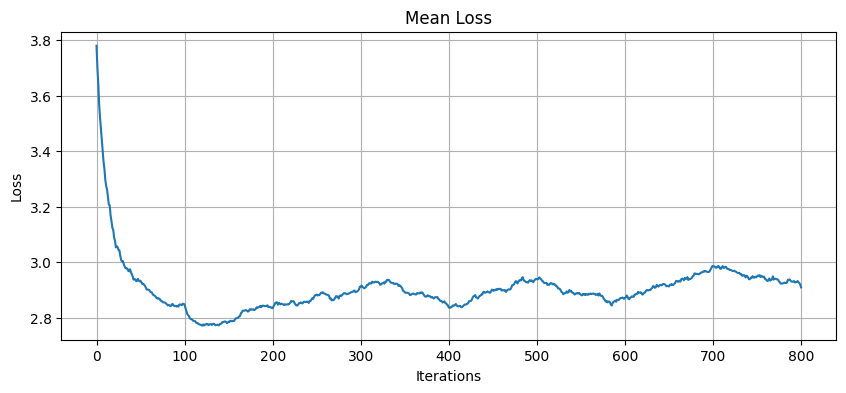

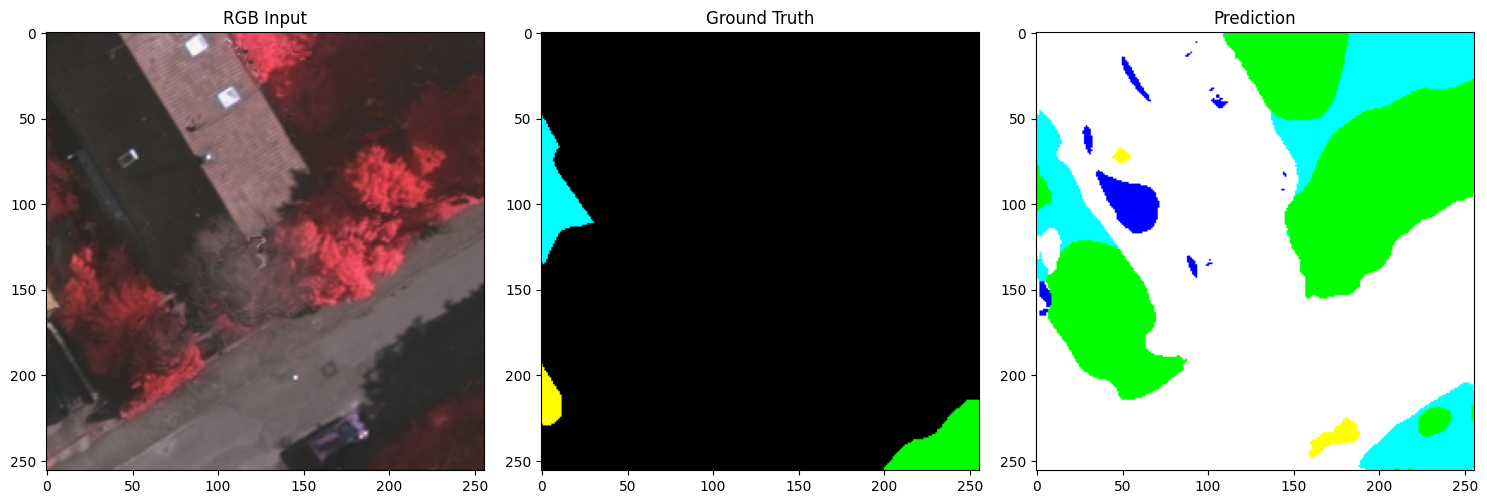

Epoch 1/1 [900/1000 (90%)] Loss: 3.1967 Acc: 6.47%


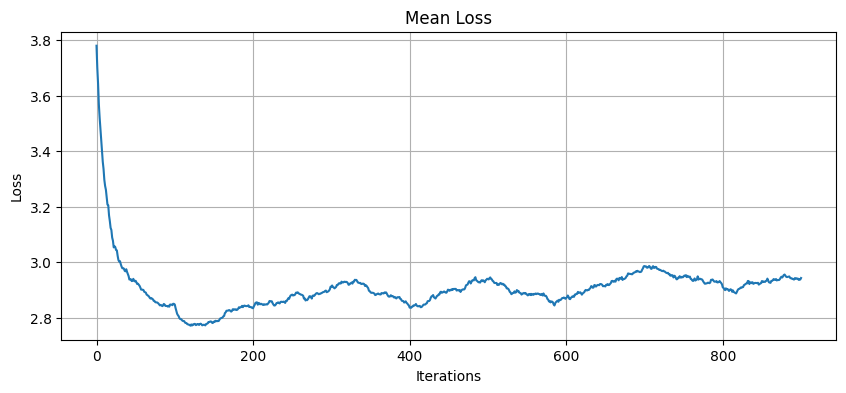

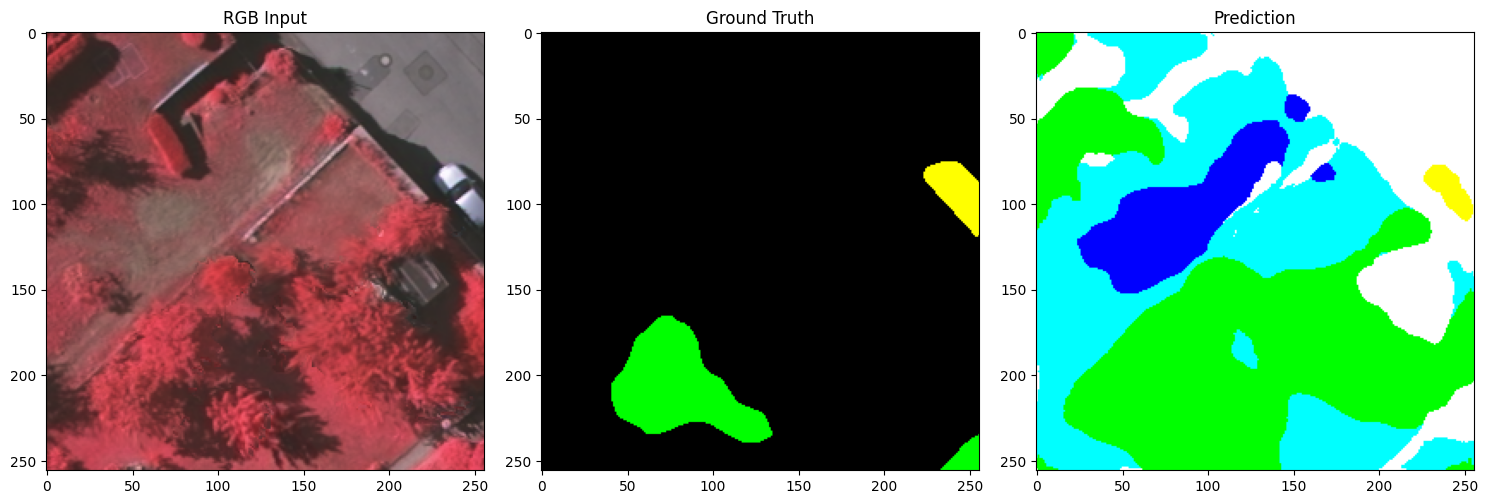

Final model saved to /kaggle/working/output/CRFNet_Vaihingen_conncomp/model_final.pth
Training completed! Model saved to /kaggle/working/output/CRFNet_Vaihingen_conncomp/model_final.pth


In [11]:
# Cell 8: Run Training (Optional)
# Uncomment to train the model
# Set TRAIN_MODEL to True to train, False to skip training
TRAIN_MODEL = True

if TRAIN_MODEL:
    print("Starting model training...")
    model_path = train_model(
        net=net,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        epochs=EPOCHS,
        save_epoch=SAVE_EPOCH,
        weights=WEIGHTS
    )
    print(f"Training completed! Model saved to {model_path}")
else:
    print("Skipping model training. Will use pre-trained model for testing.")
    # You can specify a pre-trained model path here
    model_path = f'{OUTPUT_ROOT}/{EXPERIMENT_NAME}/model_final.pth'

In [14]:
# Define paths
DATA_FOLDER = INPUT_ROOT + '/top/top_mosaic_09cm_area{}.tif'
LABEL_FOLDER = INPUT_ROOT + '/gt/top_mosaic_09cm_area{}.tif'
ERODED_FOLDER = INPUT_ROOT + '/gt_eroded/top_mosaic_09cm_area{}_noBoundary.tif'

# Load test data
test_images = [1/255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids]
test_labels = [np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids]
eroded_labels = [convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids]

# Create output directory
os.makedirs(f"{OUTPUT_ROOT}/{EXPERIMENT_NAME}", exist_ok=True)

# Test the model
accuracy, all_preds, all_gts = test_model(
    net=net,
    test_ids=test_ids,
    test_images=test_images,
    test_labels=test_labels,
    eroded_labels=eroded_labels,
    labels=LABELS,
    stride=STRIDE,
    batch_size=BATCH_SIZE,
    window_size=WINDOW_SIZE,
    output_path=f"{OUTPUT_ROOT}/{EXPERIMENT_NAME}"
)

NameError: name 'INPUT_ROOT' is not defined

In [ ]:
# List the directory structure
!ls -la /kaggle/input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/

In [ ]:
# Cell 10: Visualization of Results (if testing was performed)
if TEST_MODEL and 'all_preds' in locals():
    print("Generating visualization of results...")
    
    # Create a visualization of all test results
    n_images = len(test_ids)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    
    for i, (id, pred, gt) in enumerate(zip(test_ids, all_preds, all_gts)):
        # Load original image
        img = io.imread(DATA_FILES.format(id))
        
        # Display original image, ground truth, and prediction
        if n_images > 1:
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Area {id} - Original')
            axes[i, 1].imshow(convert_to_color(gt))
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow(convert_to_color(pred))
            axes[i, 2].set_title('Prediction')
        else:
            axes[0].imshow(img)
            axes[0].set_title(f'Area {id} - Original')
            axes[1].imshow(convert_to_color(gt))
            axes[1].set_title('Ground Truth')
            axes[2].imshow(convert_to_color(pred))
            axes[2].set_title('Prediction')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_ROOT}/{EXPERIMENT_NAME}/all_results.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Results visualization saved to {OUTPUT_ROOT}/{EXPERIMENT_NAME}/all_results.png")

print("Pipeline completed successfully!")

In [ ]:
# # Import required libraries
# import torch
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import io
# from skimage.morphology import disk  # Import disk directly from skimage.morphology
# from glob import glob
# import random
# import os
# from tqdm.notebook import tqdm
# import cv2

# # Import project modules
# from dataset.dataset import ISPRS_dataset
# from net.net import CRFNet
# from net.loss import CrossEntropy2d
# from utils.utils_dataset import convert_to_color, convert_from_color
# from utils.utils_network import compute_class_weight
# from utils.utils import accuracy

In [ ]:
# # Configuration Cell - Edit parameters here
# # ---------------------------------------------------

# # Dataset parameters
# DATASET = 'Vaihingen'
# FOLDER = "../input/potsdamvaihingen/"  # Path to dataset
# MAIN_FOLDER = FOLDER + 'ISPRS_semantic_labeling_Vaihingen/'
# DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
# LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'

# # Data split
# train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
# test_ids = ['5', '21', '15', '30']

# # Input and preprocessing parameters
# WINDOW_SIZE = (256, 256)  # Patch size
# STRIDE = 32  # Stride for testing
# IN_CHANNELS = 3  # Number of input channels (e.g. RGB)
# CACHE = True  # Store the dataset in-memory
# ERO_DISK_SIZE = 3  # Size of the morphological disk for erosion

# # Class definitions
# LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]  # Label names
# N_CLASSES = len(LABELS)  # Number of classes

# # Training parameters
# BATCH_SIZE = 10  # Number of samples in a mini-batch
# EPOCHS = 30  # Number of training epochs
# SAVE_EPOCH = 10  # Save model every N epochs
# OUTPUT_FOLDER = "./output"  # Output directory

# # Optimization parameters
# base_lr = 0.01  # Base learning rate
# MOMENTUM = 0.9  # Momentum for SGD optimizer
# WEIGHT_DECAY = 0.0005  # Weight decay for regularization
# LR_STEPS = [25, 35, 45]  # Steps for learning rate decay
# LR_GAMMA = 0.1  # Gamma factor for learning rate decay

# # Model parameters
# BILINEAR = True  # Whether to use bilinear upsampling in the model

# # Visualization parameters
# DISPLAY_ITER = 100  # Display progress every N iterations

# # Create output directory if it doesn't exist
# import os
# os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# # Initialize weights for class balancing
# WEIGHTS = torch.ones(N_CLASSES)  # Weights for class balancing

# print("Configuration loaded!")

In [ ]:
# print("Tiles for training:", train_ids)
# print("Tiles for testing:", test_ids)

# # Initialize training and test datasets
# train_set = ISPRS_dataset(
#     ids=train_ids,
#     ids_type='TRAIN',
#     gt_type='full',  # Options: 'full', 'conncomp', 'ero'
#     gt_modification=disk(ERO_DISK_SIZE),  # Erosion disk
#     data_files=DATA_FOLDER,
#     label_files=LABEL_FOLDER,
#     window_size=WINDOW_SIZE,
#     cache=CACHE,
#     augmentation=True  # Enable data augmentation for training
# )

# test_set = ISPRS_dataset(
#     ids=test_ids,
#     ids_type='TEST',
#     gt_type='full',
#     gt_modification=disk(ERO_DISK_SIZE),
#     data_files=DATA_FOLDER,
#     label_files=LABEL_FOLDER,
#     window_size=WINDOW_SIZE,
#     cache=CACHE,
#     augmentation=False  # No augmentation for testing
# )

# # Create data loaders
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

# # Initialize the model
# net = CRFNet(n_channels=IN_CHANNELS, n_classes=N_CLASSES, bilinear=BILINEAR)

# # Move model to GPU if available
# if torch.cuda.is_available():
#     net.cuda()
#     WEIGHTS = WEIGHTS.cuda()

# # Set up optimizer with different learning rates for encoder and decoder
# params_dict = dict(net.named_parameters())
# params = []
# for key, value in params_dict.items():
#     if '_D' in key:
#         # Decoder weights are trained at the nominal learning rate
#         params += [{'params': [value], 'lr': base_lr}]
#     else:
#         # Encoder weights are trained at lr / 2
#         params += [{'params': [value], 'lr': base_lr / 2}]

# optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, LR_STEPS, gamma=LR_GAMMA)

# print("Setup complete! Ready to train.")

In [ ]:
# # # Parameters
# # WINDOW_SIZE = (256, 256) # Patch size
# # STRIDE = 32 # Stride for testing
# # IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
# # FOLDER = "../input/potsdamvaihingen/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
# # BATCH_SIZE = 10 # Number of samples in a mini-batch

# # LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
# # N_CLASSES = len(LABELS) # Number of classes
# # WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
# # CACHE = True # Store the dataset in-memory

# # DATASET = 'Vaihingen'
# # MAIN_FOLDER = FOLDER + 'ISPRS_semantic_labeling_Vaihingen/'
# # DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
# # LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'

# # # ISPRS color palette
# # # Let's define the standard ISPRS color palette
# # palette = {0 : (255, 255, 255), # Impervious surfaces (white)
# #            1 : (0, 0, 255),     # Buildings (blue)
# #            2 : (0, 255, 255),   # Low vegetation (cyan)
# #            3 : (0, 255, 0),     # Trees (green)
# #            4 : (255, 255, 0),   # Cars (yellow)
# #            5 : (255, 0, 0),     # Clutter (red)
# #            6 : (0, 0, 0)}       # Undefined (black)

# # invert_palette = {v: k for k, v in palette.items()}

# # We load one tile from the dataset and we display it
# img = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area1.tif')
# fig = plt.figure()
# fig.add_subplot(121)
# plt.imshow(img)

# # We load the ground truth
# gt = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area1.tif')
# fig.add_subplot(122)
# plt.imshow(gt)
# plt.show()

In [ ]:
# # Training function
# def train_model():
#     losses = np.zeros(1000000)
#     mean_losses = np.zeros(100000000)
#     all_epoch_losses = []  # Track average loss per epoch

#     iter_ = 0

#     for e in tqdm(range(1, EPOCHS + 1)):
#         net.train()
#         epoch_losses = []  # Track losses for this epoch
#         last_batch_data = None  # Store the last batch data for visualization
        
#         for batch_idx, (data, target) in enumerate(train_loader):
#             # Process target for multi-scale supervision
#             target = target.data.cpu().numpy()
#             target = np.transpose(target, [1, 2, 0])
#             target3 = np.transpose(cv2.resize(target, dsize=(128, 128), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
#             target2 = np.transpose(cv2.resize(target, dsize=(64, 64), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
#             target1 = np.transpose(cv2.resize(target, dsize=(32, 32), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
#             target = np.transpose(target, [2, 0, 1])

#             # Move data to GPU
#             data, target = data.cuda(), torch.from_numpy(target).cuda()

#             # Save the last batch for visualization
#             if batch_idx == len(train_loader) - 1:
#                 last_batch_data = (data, target)

#             optimizer.zero_grad()

#             # Forward pass
#             output, out_fc, out_neigh, _ = net(data)

#             # Calculate losses at different scales
#             loss = CrossEntropy2d(output, target, weight=WEIGHTS)
#             loss_fc1 = CrossEntropy2d(
#                 out_fc[0],
#                 torch.from_numpy(target1).type(torch.LongTensor).cuda(),
#                 weight=compute_class_weight(target1).cuda()
#             )
#             loss_fc2 = CrossEntropy2d(
#                 out_fc[1],
#                 torch.from_numpy(target2).type(torch.LongTensor).cuda(),
#                 weight=compute_class_weight(target2).cuda()
#             )
#             loss_fc3 = CrossEntropy2d(
#                 out_fc[2],
#                 torch.from_numpy(target3).type(torch.LongTensor).cuda(),
#                 weight=compute_class_weight(target3).cuda()
#             )

#             # Pairwise loss for neighborhood consistency
#             pairwise_loss = CrossEntropy2d(out_neigh, target, weight=WEIGHTS)

#             # Combine all losses
#             total_loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss

#             # Backward pass and optimization
#             total_loss.backward()
#             optimizer.step()

#             # Record loss
#             loss_value = total_loss.item()
#             epoch_losses.append(loss_value)
#             losses[iter_] = loss_value
#             mean_losses[iter_] = np.mean(losses[max(0, iter_-100):iter_])
            
#             # Print occasional progress without images
#             if iter_ % DISPLAY_ITER == 0:
#                 print(f'Train (epoch {e}/{EPOCHS}) [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss_value:.6f}')
            
#             iter_ += 1
        
#         # End of epoch - calculate average loss
#         avg_epoch_loss = np.mean(epoch_losses)
#         all_epoch_losses.append(avg_epoch_loss)
        
#         # Visualize results at the end of each epoch
#         if last_batch_data is not None:
#             with torch.no_grad():
#                 net.eval()  # Switch to evaluation mode
#                 data, target = last_batch_data
                
#                 # Forward pass in eval mode
#                 output, _, _, _ = net(data)
                
#                 # Convert data back to CPU for visualization
#                 rgb = np.asarray(255 * np.transpose(data.cpu().numpy()[0], (1, 2, 0)), dtype='uint8')
#                 pred = np.argmax(output.detach().cpu().numpy()[0], axis=0)
#                 gt = target.cpu().numpy()[0]

#                 # Calculate accuracy
#                 acc_value = accuracy(pred, gt)
#                 if np.isnan(acc_value):
#                     acc_value = 0.0

#                 # Print epoch summary
#                 print(f'Epoch {e}/{EPOCHS} completed. Average Loss: {avg_epoch_loss:.6f} Accuracy: {acc_value:.2f}%')

#                 # Plot loss curve for all epochs so far
#                 plt.figure(figsize=(10, 4))
#                 plt.plot(all_epoch_losses)
#                 plt.title(f'Average Loss per Epoch (Current: {avg_epoch_loss:.4f})')
#                 plt.xlabel('Epoch')
#                 plt.ylabel('Loss')
#                 plt.grid(True)
#                 plt.show()

#                 # Visualize results
#                 fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
#                 ax1.imshow(rgb)
#                 ax1.set_title('RGB Input')
#                 ax2.imshow(convert_to_color(gt))
#                 ax2.set_title('Ground Truth')
#                 ax3.imshow(convert_to_color(pred))
#                 ax3.set_title(f'Prediction (Accuracy: {acc_value:.2f}%)')
#                 plt.tight_layout()
#                 plt.show()
                
#                 # Switch back to training mode
#                 net.train()

#         # Update learning rate scheduler
#         scheduler.step()

#         # Save model checkpoint
#         if e % SAVE_EPOCH == 0:
#             torch.save(net.state_dict(), f'{OUTPUT_FOLDER}/model_epoch{e}.pth')

#     # Save final model
#     torch.save(net.state_dict(), f'{OUTPUT_FOLDER}/model_final.pth')
#     print("Training completed!")

# # Execute this line to start training
# # train_model()

In [ ]:
# # Define testing function
# from net.test_network import test

# def evaluate_model(model_path):
#     """Evaluate the trained model on the test set"""
#     print(f"Loading model from {model_path}")
#     net.load_state_dict(torch.load(model_path))
#     net.eval()
    
#     print("Preparing test data...")
#     # Load test images and labels
#     test_images = [1/255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids]
#     test_labels = [np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids]
    
#     print("Running evaluation...")
#     # Evaluate the model
#     all_preds = []
#     all_gts = []
    
#     with torch.no_grad():
#         for i, (img, gt) in enumerate(zip(test_images, test_labels)):
#             print(f"Processing test image {i+1}/{len(test_images)} (Area {test_ids[i]})")
            
#             # Process the ground truth
#             gt_processed = convert_from_color(gt)
#             all_gts.append(gt_processed)
            
#             # Prepare the image tensor
#             img = np.transpose(img, (2, 0, 1))  # CHW format
            
#             # Slide window over the image
#             pred = np.zeros(gt_processed.shape, dtype=int)
#             counts = np.zeros(gt_processed.shape, dtype=int)
            
#             for x in range(0, img.shape[1] - WINDOW_SIZE[0] + 1, STRIDE):
#                 for y in range(0, img.shape[2] - WINDOW_SIZE[1] + 1, STRIDE):
#                     # Extract patch
#                     patch = img[:, x:x+WINDOW_SIZE[0], y:y+WINDOW_SIZE[1]]
#                     patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                    
#                     # Forward pass
#                     outputs = net(patch_tensor)[0]
                    
#                     # Get predictions
#                     patch_pred = np.argmax(outputs.cpu().numpy()[0], axis=0)
                    
#                     # Update prediction and counts
#                     pred[x:x+WINDOW_SIZE[0], y:y+WINDOW_SIZE[1]] += patch_pred
#                     counts[x:x+WINDOW_SIZE[0], y:y+WINDOW_SIZE[1]] += 1
            
#             # Average predictions
#             pred = np.divide(pred, counts, where=counts>0)
#             all_preds.append(pred)
            
#             # Visualize results
#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
#             ax1.imshow(np.transpose(img, (1, 2, 0)))
#             ax1.set_title(f'Test Image (Area {test_ids[i]})')
#             ax2.imshow(convert_to_color(gt_processed))
#             ax2.set_title('Ground Truth')
#             ax3.imshow(convert_to_color(pred))
#             ax3.set_title('Prediction')
#             plt.tight_layout()
#             plt.show()

#     # Calculate metrics
#     from utils.utils import metrics
#     print("\nComputing overall metrics...")
#     metrics(
#         np.concatenate([p.flatten() for p in all_preds]),
#         np.concatenate([g.flatten() for g in all_gts]),
#         LABELS
#     )
    
#     return all_preds, all_gts

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# # Optionally run evaluation
# # Uncomment the lines below to evaluate the model after training
# OUTPUT_FOLDER = "/kaggle/input/best-model2/pytorch/default/1"
# final_model_path = f'{OUTPUT_FOLDER}/model_final.pth'
# all_preds, all_gts = evaluate_model(final_model_path)